# Setup

In [1]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from pathlib import Path
import IPython.display as ipd
import sklearn as skl
import pandas as pd
from IPython.display import Image

import tensorflow as tf
from tensorflow.keras import layers, models, metrics

import utils

In [2]:
gtzan_dir = Path(str(os.environ.get('GTZAN_DIR')))   #C:/VisualStudioRepositories/MUSIC_DATA/gt/Data
fma_dir = Path(str(os.environ.get('FMA_DIR')))       #C:/VisualStudioRepositories/MUSIC_DATA/fma

gtzan_audio_dir = gtzan_dir / 'genres_original'
gtzan_image_dir = gtzan_dir / 'spectrograms'
gtzan_df_path = gtzan_dir / 'gtzan_df.csv'

fma_small_audio_dir = fma_dir / 'fma_small'
fma_small_image_dir = fma_dir / 'spectrograms/fma_small'

fma_medium_audio_dir = fma_dir / 'fma_medium'
fma_medium_image_dir = fma_dir / 'spectrograms/fma_medium'

fma_df_path = fma_dir / 'fma_df.csv'

In [3]:
gtzan_classes = ['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock'] #10
fma_top_classes = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock'] #8

In [4]:
IMAGE_SIZE = 128    #128x128 px images for the CNN (with 3 channels)

# GTZAN spectrograms

Example of a spectrogram included with the Kaggle GTZAN dataset

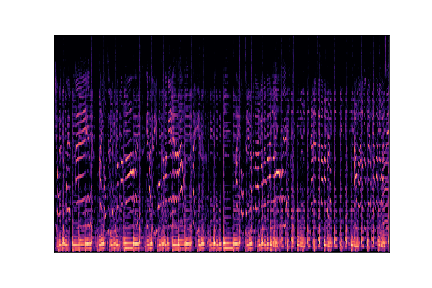

In [ ]:
# size: 432 x 288
# uses amplitude_to_db instead of power_to_db
Image(filename = gtzan_dir / 'images_original/rock/rock00040.png')

Create own spectrogram

In [19]:
FRAME_SIZE = 2048
HOP_SIZE = 512
N_MELS = 128

In [6]:
x_amp, sr_amp = librosa.load(gtzan_dir / 'genres_original/rock/rock.00040.wav', sr=None, mono=True)
ipd.Audio(x_amp, rate=sr_amp)

In [20]:
spectrogram_mel = librosa.feature.melspectrogram(y=x_amp, sr=sr_amp, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, n_mels=N_MELS)
spectrogram_mel.shape # (n_mels, frames)

spectrogram_mel_log = librosa.power_to_db(spectrogram_mel, ref=np.max)
spectrogram_mel_log.shape # (n_mels, frames)

(128, 1293)

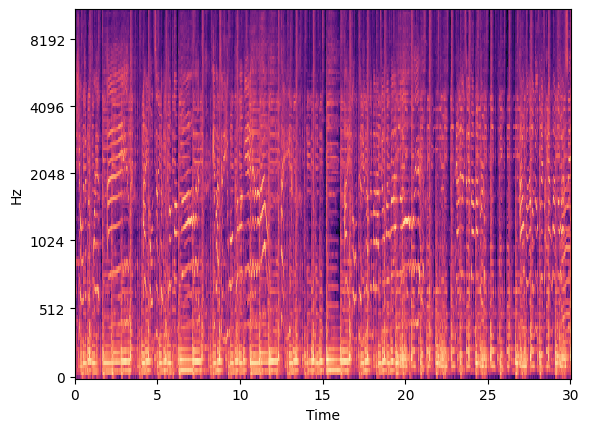

In [10]:
fig1, ax1 = plt.subplots()
librosa.display.specshow(spectrogram_mel_log, sr=sr_amp, x_axis='time', y_axis='mel', ax=ax1)
plt.show()

Create an example of final result (128 x 128 mel spectrogram) prepared for the CNN

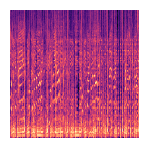

In [17]:
DPI = 100
PX = 1/DPI
BORDER_SIZE = 30.5 #px
SIZE_PX = IMAGE_SIZE + BORDER_SIZE #128px + 30.5px white border which won't be included in the final img

fig2, ax2 = plt.subplots(figsize=(SIZE_PX*PX, SIZE_PX*PX), dpi=DPI)
ax2.axis('off')
fig2.tight_layout()
librosa.display.specshow(spectrogram_mel_log, sr=sr_amp, x_axis='time', y_axis='mel', ax=ax2, auto_aspect=True)
plt.show()

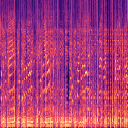

In [18]:
# Result is 128x128 px
fig2.savefig(fname="../output/images/sample_gtzan.png", bbox_inches='tight', pad_inches=0, dpi=DPI)
Image(filename="../output/images/sample_gtzan.png")

# 128x128 Mel spectrogram file creation

Create spectrograms saved in the following output file structure:

---output_base_path

----------parent_folder1

--------------------spectrogram1

--------------------spectrogram2

--------------------...

----------parent_folder2

--------------------spectrogram1

--------------------...

----------...

Output parent folders are named after parent folders from the input filepaths.

Files do not have to be divided into parent folders by class (e.g. GTZAN is divided by class, but FMA is divided by IDs).

In [5]:
def calculate_mel_spectrogram(x_amp, sr_amp, n_fft=2048, hop_length=512, n_mels=128):
    spectrogram_mel = librosa.feature.melspectrogram(y=x_amp, sr=sr_amp, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    spectrogram_mel_log = librosa.power_to_db(spectrogram_mel, ref=np.max)
    return spectrogram_mel_log

def create_mel_spectrogram_plt(spectrogram_mel_log, sr_amp, image_size=128):
    DPI = 100
    PX = 1/DPI
    BORDER_SIZE = 30.5 #px
    SIZE_PX = image_size + BORDER_SIZE #128 + 30.5 white border which won't be included in the final img

    fig, ax = plt.subplots(figsize=(SIZE_PX*PX, SIZE_PX*PX), dpi=DPI)
    ax.axis('off')
    fig.tight_layout()
    librosa.display.specshow(spectrogram_mel_log, sr=sr_amp, x_axis='time', y_axis='mel', ax=ax, auto_aspect=True)
    return fig

def create_and_save_mel_spectrogram(x_amp, sr_amp, output_base_path, parent_folder, filename, image_size=128):
    # skip already existing files
    # for example fma-small is a subset of fma-medium
    # so some spectrograms might have been created earlier
    if os.path.exists(output_base_path / parent_folder / filename):
        return
    
    spectrogram_mel_log = calculate_mel_spectrogram(x_amp, sr_amp)
    fig = create_mel_spectrogram_plt(spectrogram_mel_log, sr_amp, image_size)
    
    # create parent folder if it doesn't exist
    if not os.path.exists(output_base_path / parent_folder):
        os.makedirs(output_base_path / parent_folder)
    
    fig.savefig(fname= output_base_path / parent_folder / filename, bbox_inches='tight', pad_inches=0, dpi=100)
    plt.close(fig)

In [ ]:
def create_spectrograms_for_files(filepaths, output_base_path):
    for audio_filepath in filepaths:
        try:
            x_amp, sr_amp = librosa.load(audio_filepath, sr=None, mono=True)
            
            parent_folder = Path(audio_filepath.parent.name)
            filename = Path(audio_filepath.stem + '.png')
            
            create_and_save_mel_spectrogram(x_amp, sr_amp, output_base_path, parent_folder, filename)
        except: #in case of faulty audio files
            print(f'ERROR: {audio_filepath} could not be processed')
            continue

# GTZAN spectrogram creation

Faulty files:

> jazz.00054 - can't be loaded

> reggae.00086 - very distorted

Faulty files have been removed from working audio directory.

In [ ]:
gtzan_audio_filepaths = list(gtzan_audio_dir.rglob('*.wav'))

In [ ]:
# GTZAN INPUT:
# C:/VisualStudioRepositories/MUSIC_DATA/gt/Data/genres_original/    Blues/blues.00000.wav (parent + filename)

# GTZAN OUTPUT:
# C:/VisualStudioRepositories/MUSIC_DATA/gt/Data/spectrograms/       Blues/blues.00000.png (parent + filename)

create_spectrograms_for_files(gtzan_audio_filepaths, gtzan_image_dir)

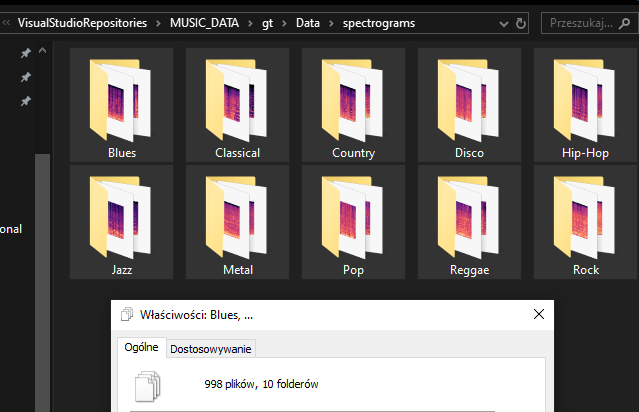

In [5]:
Image(filename='../output/images/gtzan_spectr.png')

# FMA-small spectrogram creation

Faulty files:
> 99134 can't be loaded at all

> 108925 can't be loaded at all

> 133297 can't be loaded at all

> 98565 lasts only 1.6s

> 98567 lasts only 0.5s

> 98569 lasts only 1.5s

Faulty files have been removed from working audio directory and moved to FAULTY_FILES/fma_small.

In [ ]:
fma_audio_filepaths = list(fma_small_audio_dir.rglob('*.mp3'))

In [ ]:
# FMA-SMALL INPUT:
# C:/VisualStudioRepositories/MUSIC_DATA/fma/fma_small/                  000/000002.mp3 (parent + filename)

# FMA-SMALL OUTPUT:
# C:/VisualStudioRepositories/MUSIC_DATA/fma/spectrograms/fma_small/     000/000002.png (parent + filename)

create_spectrograms_for_files(fma_audio_filepaths, fma_small_image_dir)

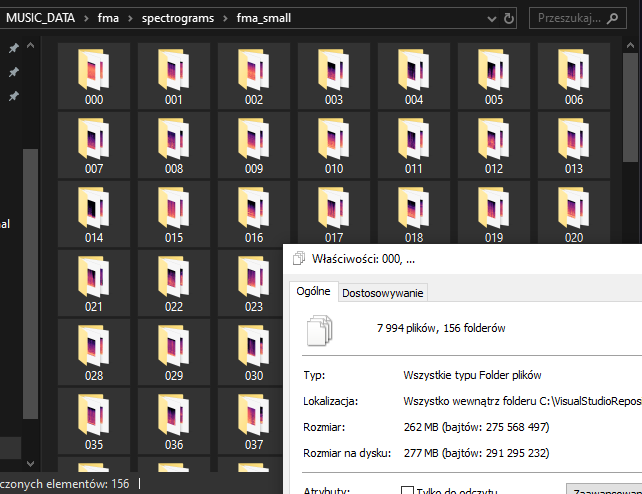

In [6]:
Image(filename='../output/images/fma_spectr.png')

# FMA-medium spectrogram creation

21 faulty files specified in FMA Github page.

https://github.com/mdeff/fma/wiki

In [ ]:
# move faulty files to a separate folder (FAULTY_AUDIO/fma_medium)
faulty_fma_medium_files = ['fma_medium/001/001486.mp3',
                           'fma_medium/005/005574.mp3',
                           'fma_medium/065/065753.mp3',
                           'fma_medium/080/080391.mp3',
                           'fma_medium/098/098558.mp3',
                           'fma_medium/098/098559.mp3',
                           'fma_medium/098/098560.mp3',
                           'fma_medium/098/098565.mp3',
                           'fma_medium/098/098566.mp3',
                           'fma_medium/098/098567.mp3',
                           'fma_medium/098/098568.mp3',
                           'fma_medium/098/098569.mp3',
                           'fma_medium/098/098571.mp3',
                           'fma_medium/099/099134.mp3',
                           'fma_medium/105/105247.mp3',
                           'fma_medium/108/108924.mp3',
                           'fma_medium/108/108925.mp3',
                           'fma_medium/126/126981.mp3',
                           'fma_medium/127/127336.mp3',
                           'fma_medium/133/133297.mp3',
                           'fma_medium/143/143992.mp3']

print(len(faulty_fma_medium_files))

fma_medium_faulty_dir = fma_dir / 'FAULTY_AUDIO' / 'fma_medium'
[os.rename(Path(fma_dir / file), Path(fma_medium_faulty_dir / Path(file).name)) for file in faulty_fma_medium_files]

21

In [ ]:
fma_medium_audio_filepaths = list(fma_medium_audio_dir.rglob('*.mp3'))
len(fma_medium_audio_filepaths)

24979

In [ ]:
# FMA-MEDIUM INPUT:
# C:/VisualStudioRepositories/MUSIC_DATA/fma/fma_medium/                  000/000002.mp3 (parent + filename)

# FMA-MEDIUM OUTPUT:
# C:/VisualStudioRepositories/MUSIC_DATA/fma/spectrograms/fma_medium/     000/000002.png (parent + filename)

create_spectrograms_for_files(fma_medium_audio_filepaths, fma_medium_image_dir)

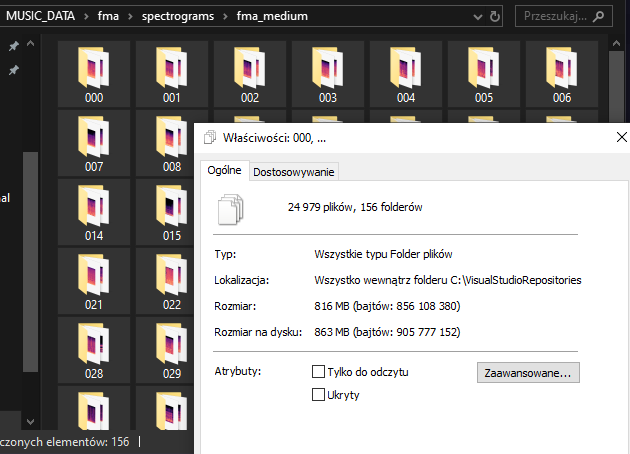

In [5]:
Image(filename='../output/images/fma_m_spectr.png')

# Create and save GTZAN dataframe

100 files for every genre except reggae and jazz which have 99 files

In [5]:
#path - relative spectrogram image path (only parent and filename)
#set - train/validation/test
#genre - one of 10 classes
gtzan_df = pd.DataFrame(columns=['path', 'set', 'genre'])

In [6]:
# Load image filepaths
gtzan_image_filepaths = list(gtzan_image_dir.rglob('*.png'))
gtzan_image_filepaths = [Path(path.parent.name) / Path(path.name) for path in gtzan_image_filepaths]   

In [7]:
# Save filepaths and assign genres from paths
gtzan_df['path'] = gtzan_image_filepaths
gtzan_df['genre'] = gtzan_df['path'].apply(lambda x: x.parent.name)

80 songs of every genre land in train set.

Split probably could be improved by accounting for artist effect (i. e. forbiding artists in train set from appearing in test set) but GTZAN has so much artist repetition that it could be difficult to meaningfully achieve. It also has no official metadata available.

In [8]:
# Divide into sets
np.random.seed(42)
gtzan_sampled_df = gtzan_df.groupby('genre').sample(n=80, replace=False)
gtzan_df['set'] = np.where(gtzan_df['path'].isin(gtzan_sampled_df['path']), 'train', 'test')

9 songs for every class moves from test to validation

In [9]:
gtzan_test_df = gtzan_df[gtzan_df['set'] == 'test']
gtzan_test_sampled_df = gtzan_test_df.groupby('genre').sample(n=9, replace=False)
gtzan_df['set'] = np.where(gtzan_df['path'].isin(gtzan_test_sampled_df['path']), 'validation', gtzan_df['set'])

In [10]:
gtzan_df.head(4)

path         set  genre
0  Blues\blues.00000.png       train  Blues
1  Blues\blues.00001.png  validation  Blues
2  Blues\blues.00002.png  validation  Blues
3  Blues\blues.00003.png       train  Blues

In [11]:
#Save
gtzan_df.to_csv(gtzan_df_path, index=False)

# Define function loading GTZAN dataframe from file

In [25]:
def get_gtzan_dataframe(with_val):
    gtzan_df = pd.read_csv(gtzan_df_path)
    
    # turn relative paths into absolute paths
    gtzan_df['path'] = gtzan_df['path'].apply(lambda x: gtzan_image_dir / x)
    
    # SAMPLES: 800/90/108
    if (with_val):
        gtzan_train_df = gtzan_df[gtzan_df['set'] == 'train']
        gtzan_val_df = gtzan_df[gtzan_df['set'] == 'validation']
        gtzan_test_df = gtzan_df[gtzan_df['set'] == 'test']
        return gtzan_train_df, gtzan_val_df, gtzan_test_df
    else: # SAMPLES: 800/198
        gtzan_train_df = gtzan_df[gtzan_df['set'] == 'train']
        gtzan_test_df = gtzan_df[(gtzan_df['set'] == 'test') | (gtzan_df['set'] == 'validation')]
        return gtzan_train_df, gtzan_test_df

# Load GTZAN dataframe (with or without separate validation set)

In [6]:
# with separate val
gtzan_train_df, gtzan_val_df, gtzan_test_df = get_gtzan_dataframe(with_val=True)

In [ ]:
# without separate val
gtzan_train_df, gtzan_test_df = get_gtzan_dataframe(with_val=False)

# Create and save FMA dataframe

In [5]:
# contains labels for tracks
tracks_df = utils.load(fma_dir / 'fma_metadata/tracks.csv')

In [ ]:
#track_id -  id from tracks.csv
#path     -  relative spectrogram image path (only parent and filename)
#set      -  train or test
#size     -  small/medium fma dataset (note: tracks in 'small' also belong to 'medium')
#genre    -  one of 8 classes
fma_df = pd.DataFrame(columns=['track_id','path', 'set', 'size', 'genre'])

In [7]:
# Load image filepaths
fma_medium_image_filepaths = list(fma_medium_image_dir.rglob('*.png'))
fma_medium_image_filepaths = [Path(path.parent.name) / Path(path.name) for path in fma_medium_image_filepaths]   

In [8]:
# Save filepaths and assign:
# genre from track, top_genre in tracks_df
# size from set, subset in tracks_df
# set from set, split in tracks_df
fma_df['path'] = fma_medium_image_filepaths
fma_df['track_id'] = fma_df['path'].apply(lambda x: int(x.stem))

In [9]:
# train/val/test split done by fma creators, takes care of "artist effect" etc.
fma_df['genre'] = fma_df['track_id'].apply(lambda track_id: tracks_df.loc[track_id]['track']['genre_top'])
fma_df['size'] = fma_df['track_id'].apply(lambda track_id: tracks_df.loc[track_id]['set']['subset'])
fma_df['set'] = fma_df['track_id'].apply(lambda track_id: tracks_df.loc[track_id]['set']['split'])

In [12]:
fma_df.head(13)

track_id            path         set    size         genre
0          2  000\000002.png    training   small       Hip-Hop
1          3  000\000003.png    training  medium       Hip-Hop
2          5  000\000005.png    training   small       Hip-Hop
3         10  000\000010.png    training   small           Pop
4        134  000\000134.png    training  medium       Hip-Hop
5        136  000\000136.png    training  medium          Rock
6        139  000\000139.png    training  medium          Folk
7        140  000\000140.png    training   small          Folk
8        141  000\000141.png    training   small          Folk
9        148  000\000148.png  validation   small  Experimental
10       181  000\000181.png        test  medium          Rock
11       182  000\000182.png        test   small          Rock
12       190  000\000190.png    training   small          Folk

In [ ]:
#Save
fma_df.to_csv(fma_df_path, index=False)

# Define function loading FMA dataframe from file

In [5]:
def get_fma_dataframe(get_fma_small, with_val):
    fma_df = pd.read_csv(fma_df_path)
    
    # turn relative paths into absolute paths
    fma_df['path'] = fma_df['path'].apply(lambda x: fma_medium_image_dir / x)
    
    # otherwise the dataset is FMA-medium
    if (get_fma_small):
        fma_df = fma_df[fma_df['size'] == 'small']
    
    # PERCENTAGES: 80/10/10
    if (with_val):
        fma_train_df = fma_df[fma_df['set'] == 'training']
        fma_val_df = fma_df[fma_df['set'] == 'validation']
        fma_test_df = fma_df[fma_df['set'] == 'test']
        return fma_train_df, fma_val_df, fma_test_df
    else: # PERCENTAGES: 80/20
        fma_train_df = fma_df[fma_df['set'] == 'training']
        fma_test_df = fma_df[(fma_df['set'] == 'test') | (fma_df['set'] == 'validation')]
        return fma_train_df, fma_test_df

# Load FMA dataframe (with or without separate validation set) (small or medium)

In [6]:
# fma-small with separate val
fma_small_train_df, fma_small_val_df, fma_small_test_df = get_fma_dataframe(get_fma_small=True, with_val=True)

In [ ]:
# fma-small without separate val
fma_small_train_df, fma_small_test_df = get_fma_dataframe(get_fma_small=True, with_val=False)

In [ ]:
# fma-medium with separate val
fma_medium_train_df, fma_medium_val_df, fma_medium_test_df = get_fma_dataframe(get_fma_small=False, with_val=True)

In [ ]:
# fma-medium without separate val
fma_medium_train_df, fma_medium_test_df = get_fma_dataframe(get_fma_small=False, with_val=False)

# Define input data loading functions

Based on https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control

In [7]:
# class names get turned into 0, 1, 2, 3, ... to be used with sparse_categorical_crossentropy
def encode_class_label(class_name, available_classes):
  numerical_label = class_name == available_classes
  return tf.argmax(numerical_label)

In [8]:
# decode png
def decode_img_data(img_data, channels=3):
  img_data = tf.io.decode_png(img_data, channels=channels)
  return tf.image.resize(img_data, [IMAGE_SIZE, IMAGE_SIZE])

In [9]:
# return pair: decoded png and class name turned into numerical label
def process_sample(sample, available_classes, channels=3):
  img_path = sample[0]
  class_label = sample[1]
  
  img_data = tf.io.read_file(img_path)
  img_data = decode_img_data(img_data, channels)
  numerical_label = encode_class_label(class_label, available_classes)
  return img_data, numerical_label

In [10]:
def configure_for_performance(ds, batch_size=8):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

In [11]:
# path&genre pairs from dataframe -> image data&numerically-encoded label pairs as dataset
def prepare_dataset_based_on_df(df, available_classes, batch_size=8, channels=3):
    df.loc[:, 'path'] = df['path'].apply(lambda x: str(x)) # !copy-on-write warning fixed with the loc
    ds = tf.data.Dataset.from_tensor_slices((df['path'], df['genre']))
    
    print("Example data:")
    [print(d[0].numpy(), d[1].numpy()) for d in ds.take(3)]
        
    print(f'Data set size: {tf.data.experimental.cardinality(ds).numpy()}')    
    
    # Use Dataset.map to create a Dataset of (image data, numerically-encoded label) pairs:
    ds = ds.map(lambda *d: process_sample(d, available_classes, channels),
                num_parallel_calls=tf.data.AUTOTUNE)
    
    ds = configure_for_performance(ds, batch_size)

    return ds

In [12]:
def visualize_samples_from_dataset_batch(ds, available_classes, samples=6):
    image_batch, label_batch = next(iter(ds))
    samples = samples if samples <= len(label_batch) else len(label_batch)
    
    fig, axes = plt.subplots(ncols=3, nrows=(samples + 2) // 3)
    [axis.set_axis_off() for axis in axes.ravel()]
    
    for i in range(samples):
        ax = axes.flat[i]
        ax.imshow(image_batch[i].numpy().astype("uint8"))
        ax.set_title(available_classes[label_batch[i]])

In [13]:
# Automatic - but with no manual control over the split
#
# gtzan_image_dir = gtzan_dir / 'spectrograms'
# gtzan_train_ds = tf.keras.utils.image_dataset_from_directory(
#   gtzan_image_dir,
#   seed=42,
#   validation_split=0.2,
#   labels='inferred',
#   label_mode='categorical',
#   color_mode='rgb',
#   image_size=(IMAGE_SIZE, IMAGE_SIZE))

# CNN model building function

In [ ]:
# 4 convolutional layers
# layer 1 and 2:
#   64 kernels 5x5 each,
#   RELU,
#   batch normalization,
#   2d max pooling kernel size 2 stride 2
#   
# layer 3 and 4:
#   128 kernels 5x5 each,
#   RELU,
#   batch normalization,
#   2d max pooling - kernel size 2 stride 2
#
# dropout 0.2
#
# output:
#   fully connected linear layer

def create_CNN(img_size, channels, num_classes):
    return models.Sequential([
        layers.Input(shape=(img_size, img_size, channels)),
        
        layers.Conv2D(64, (5, 5), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),
        layers.Dropout(0.2),
        
        layers.Conv2D(64, (5, 5), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),
        layers.Dropout(0.2),
        
        layers.Conv2D(128, (5, 5), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),
        layers.Dropout(0.2),
        
        layers.Conv2D(128, (5, 5), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),
        layers.Dropout(0.2),
        
        layers.Flatten(),
        layers.Dense(num_classes, activation='softmax')
    ])

In [15]:
multiclass_metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),
                    #tf.keras.metrics.AUC(curve='ROC'),
                ]

# Load GTZAN inputs

With val

In [50]:
BATCH_SIZE = 8
CHANNELS = 3

In [51]:
gtzan_train_ds = prepare_dataset_based_on_df(gtzan_train_df, gtzan_classes, BATCH_SIZE, CHANNELS)

Example data:
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Blues\\blues.00000.png' b'Blues'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Blues\\blues.00003.png' b'Blues'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Blues\\blues.00004.png' b'Blues'
Data set size: 800


In [52]:
gtzan_val_ds = prepare_dataset_based_on_df(gtzan_val_df, gtzan_classes, BATCH_SIZE, CHANNELS)

Example data:
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Blues\\blues.00020.png' b'Blues'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Blues\\blues.00021.png' b'Blues'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Blues\\blues.00023.png' b'Blues'
Data set size: 90


In [53]:
gtzan_test_ds = prepare_dataset_based_on_df(gtzan_test_df, gtzan_classes, BATCH_SIZE, CHANNELS)

Example data:
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Blues\\blues.00001.png' b'Blues'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Blues\\blues.00002.png' b'Blues'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Blues\\blues.00014.png' b'Blues'
Data set size: 108


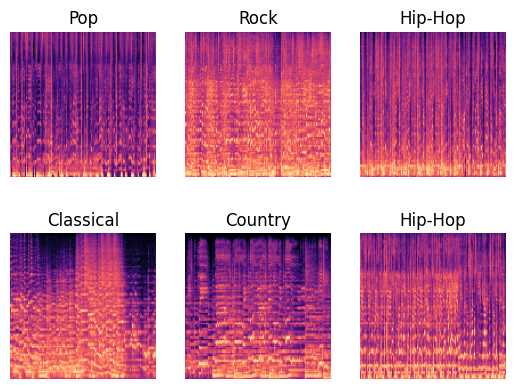

In [54]:
visualize_samples_from_dataset_batch(gtzan_train_ds, gtzan_classes, samples=6)

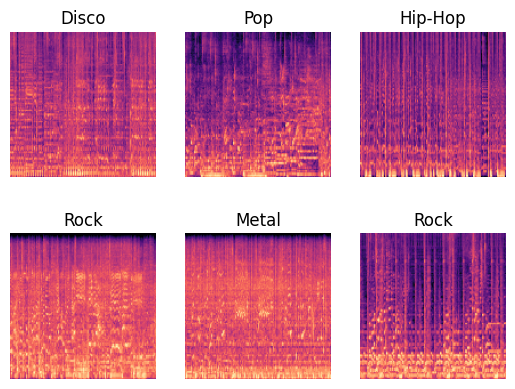

In [55]:
visualize_samples_from_dataset_batch(gtzan_val_ds, gtzan_classes, samples=6)

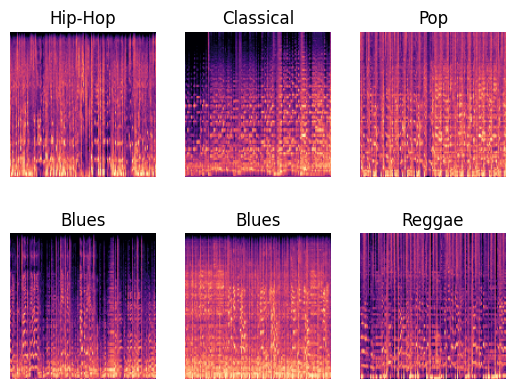

In [56]:
visualize_samples_from_dataset_batch(gtzan_test_ds, gtzan_classes, samples=6)

# Create and train GTZAN model

In [69]:
model_gtzan = create_CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_classes=len(gtzan_classes))

In [ ]:
model_gtzan.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=multiclass_metrics)

In [71]:
model_gtzan.fit(
  gtzan_train_ds,
  validation_data=gtzan_val_ds,
  epochs=8
)

Epoch 1/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - loss: 3.0470 - sparse_categorical_accuracy: 0.1773 - val_loss: 19.0924 - val_sparse_categorical_accuracy: 0.1000
Epoch 2/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - loss: 1.9345 - sparse_categorical_accuracy: 0.4122 - val_loss: 13.3910 - val_sparse_categorical_accuracy: 0.1333
Epoch 3/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - loss: 1.8065 - sparse_categorical_accuracy: 0.4629 - val_loss: 12.3684 - val_sparse_categorical_accuracy: 0.1000
Epoch 4/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - loss: 1.4122 - sparse_categorical_accuracy: 0.5336 - val_loss: 2.2010 - val_sparse_categorical_accuracy: 0.3556
Epoch 5/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - loss: 1.2348 - sparse_categorical_accuracy: 0.5394 - val_loss: 13.6368 - val_sparse_categorical_accuracy: 0.1000
Epoch 6/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - loss: 1.0755 - sparse_categorical_accuracy: 0.6627 - val_loss: 5.8251 - val_sparse_categorical_accur

In [74]:
model_gtzan.evaluate(
  gtzan_test_ds
)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.4437 - sparse_categorical_accuracy: 0.2765


[3.122779369354248, 0.25925925374031067]

# Load FMA-small inputs

With val

In [16]:
BATCH_SIZE = 8
CHANNELS = 3

In [17]:
fma_small_train_ds = prepare_dataset_based_on_df(fma_small_train_df, fma_top_classes, BATCH_SIZE, CHANNELS)
fma_small_val_ds = prepare_dataset_based_on_df(fma_small_val_df, fma_top_classes, BATCH_SIZE, CHANNELS)
fma_small_test_ds = prepare_dataset_based_on_df(fma_small_test_df, fma_top_classes, BATCH_SIZE, CHANNELS)

Example data:
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\fma\\spectrograms\\fma_medium\\000\\000002.png' b'Hip-Hop'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\fma\\spectrograms\\fma_medium\\000\\000005.png' b'Hip-Hop'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\fma\\spectrograms\\fma_medium\\000\\000010.png' b'Pop'
Data set size: 6394
Example data:
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\fma\\spectrograms\\fma_medium\\000\\000148.png' b'Experimental'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\fma\\spectrograms\\fma_medium\\000\\000459.png' b'Rock'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\fma\\spectrograms\\fma_medium\\000\\000602.png' b'Folk'
Data set size: 800
Example data:
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\fma\\spectrograms\\fma_medium\\000\\000182.png' b'Rock'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\fma\\spectrograms\\fma_medium\\000\\000704.png' b'International'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\fma\\spectrograms\\fma_medium\\000\\000705.png' b'Int

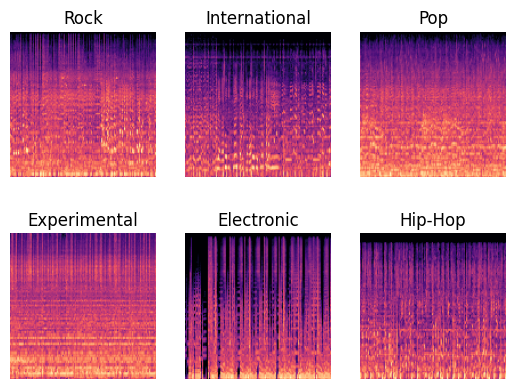

In [18]:
visualize_samples_from_dataset_batch(fma_small_train_ds, fma_top_classes, samples=6)

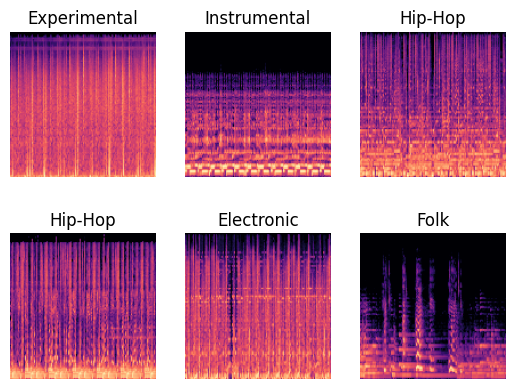

In [19]:
visualize_samples_from_dataset_batch(fma_small_val_ds, fma_top_classes, samples=6)

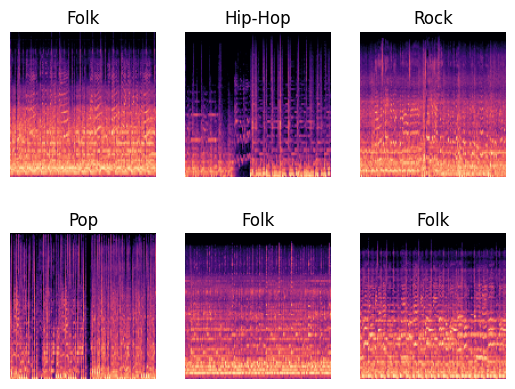

In [20]:
visualize_samples_from_dataset_batch(fma_small_test_ds, fma_top_classes, samples=6)

# Create and train FMA-small model

In [21]:
model_fma_small = create_CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_classes=len(fma_top_classes))

In [22]:
model_fma_small.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='sparse_categorical_crossentropy',
                    metrics=multiclass_metrics)

In [25]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[]

In [23]:
model_fma_small.fit(
  fma_small_train_ds,
  validation_data=fma_small_val_ds,
  epochs=8
)

Epoch 1/8
580/800 ━━━━━━━━━━━━━━━━━━━━ 26s 120ms/step - loss: 2.6975 - sparse_categorical_accuracy: 0.2289

KeyboardInterrupt: 

In [ ]:
model_fma_small.evaluate(
  fma_small_test_ds
)

# Function definition for binary classification

In [28]:
def trim_dataframe_to_binary_classification(df, class1, class2):
    return df[(df['genre'] == class1) | (df['genre'] == class2)]

# Define binary metrics

In [35]:
binary_metrics=[tf.keras.metrics.BinaryAccuracy(),
                    #tf.keras.metrics.AUC(curve='ROC'),
                ]

# GTZAN binary classification

In [ ]:
#todo - actually find the 2 best classes

In [31]:
BATCH_SIZE = 8
CHANNELS = 3

In [26]:
GTZAN_CLASS_1 = 'Classical'
GTZAN_CLASS_2 = 'Metal'
gtzan_binary_classes = [GTZAN_CLASS_1, GTZAN_CLASS_2]

In [29]:
gtzan_train_df_2 = trim_dataframe_to_binary_classification(gtzan_train_df, *gtzan_binary_classes)
gtzan_val_df_2 = trim_dataframe_to_binary_classification(gtzan_val_df,  *gtzan_binary_classes)
gtzan_test_df_2 = trim_dataframe_to_binary_classification(gtzan_test_df,  *gtzan_binary_classes)

In [32]:
gtzan_train_ds_2 = prepare_dataset_based_on_df(gtzan_train_df_2, gtzan_binary_classes, BATCH_SIZE, CHANNELS)
gtzan_val_ds_2 = prepare_dataset_based_on_df(gtzan_val_df_2, gtzan_binary_classes, BATCH_SIZE, CHANNELS)
gtzan_test_ds_2 = prepare_dataset_based_on_df(gtzan_test_df_2, gtzan_binary_classes, BATCH_SIZE, CHANNELS)

Example data:
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00000.png' b'Classical'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00001.png' b'Classical'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00002.png' b'Classical'
Data set size: 160
Example data:
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00011.png' b'Classical'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00022.png' b'Classical'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00027.png' b'Classical'
Data set size: 18
Example data:
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00004.png' b'Classical'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00006.png' b'Classical'
b'C:\\VisualStudi

In [33]:
model_gtzan_2 = create_CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_classes=2)

In [36]:
model_gtzan_2.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=binary_metrics)

In [38]:
model_gtzan_2.fit(
  gtzan_train_ds_2,
  validation_data=gtzan_val_ds_2,
  epochs=2
)

Epoch 1/2


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 2)

In [ ]:
model_gtzan_2.evaluate(
  gtzan_test_ds_2
)